In [234]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from collections import Counter
import matplotlib.patches as patches

#### Import the dataset

📕 Here, we use the train dataset available from kaggle.

In [237]:
data = pd.read_csv("train.csv", index_col=0)

📕 Let's have a look at the full dataset

In [238]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [239]:
data = data.sort_values("Neighborhood")

📕 It is made of 80 columns and 1460 rows

In [240]:
data.shape

(1460, 80)

📕 Some columns have null values as LotFrontage which has 1201 data instead of 1460.

In [241]:
pd.options.display.max_columns = None
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


📕There are no duplicates

In [242]:
data.duplicated().sum()

0

📕 Some data are strongly correlated as the Garage features between them or the Overall quality and the sale price.

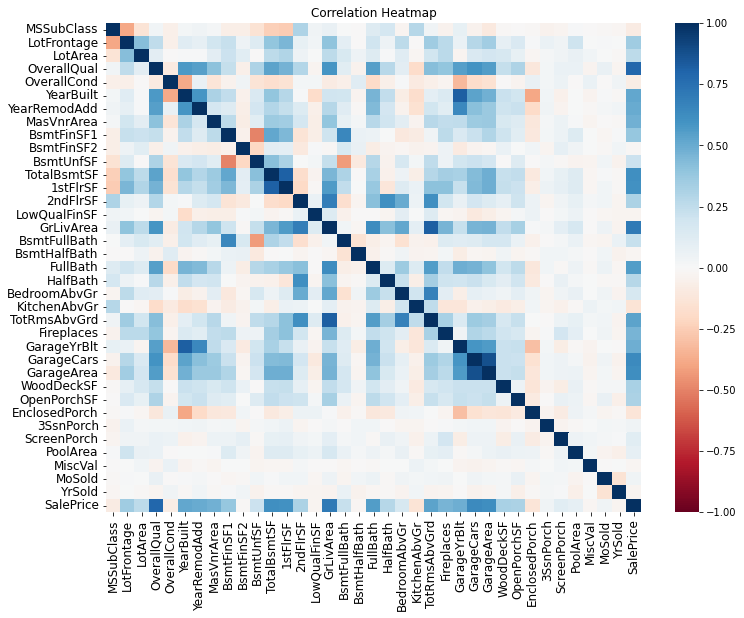

In [243]:
plt.figure(figsize=(12,9))
corr = data.corr()
s = sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0, fontsize=12)
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=12)
plt.title("Correlation Heatmap")
plt.plot()
plt.savefig('Corrmap.jpg')

📕 For the column of interest in this study -Neighborhood and SalePrice- there are no null values.

## Effect of Price on Neighborhood

📕 **In this study**, we will look at the sale price based on the neighborhoods. For this, after having a closer look at the price and neighborhood columns, we will perform a segmentation of the data using the dendrogram and KMean clustering approaches. Based, on this segmentation, we will draw conclusions.

📕For the two columns, there are no null values.

In [244]:
data["Neighborhood"].isna().sum()

0

In [245]:
data["SalePrice"].isna().sum()

0

#### Plot an histogram for the prices

We can use an histogram to have a quick visualization of the reduced dataset

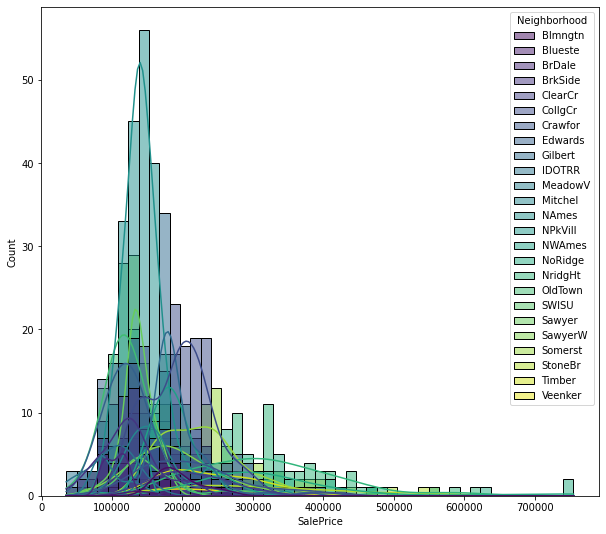

In [246]:
plt.figure(figsize=(10,9))
sns.histplot(data=data, x="SalePrice", kde=True, hue="Neighborhood", palette="viridis");
#plt.savefig('HistPrices.jpg')

In [247]:
data.shape

(1460, 80)

📕 Let's count the data and group them by neighborhood

In [337]:
proportion_neigh = data.groupby(["Neighborhood"])["Neighborhood"].count()
df_proportion_neigh = pd.DataFrame(proportion_neigh,).rename(columns={"Neighborhood": "DataCount"}).reset_index()
#df_proportion_neigh

📕 To visualize the data, I plotted the count by neighborhood and the saleprice by neighborhood.

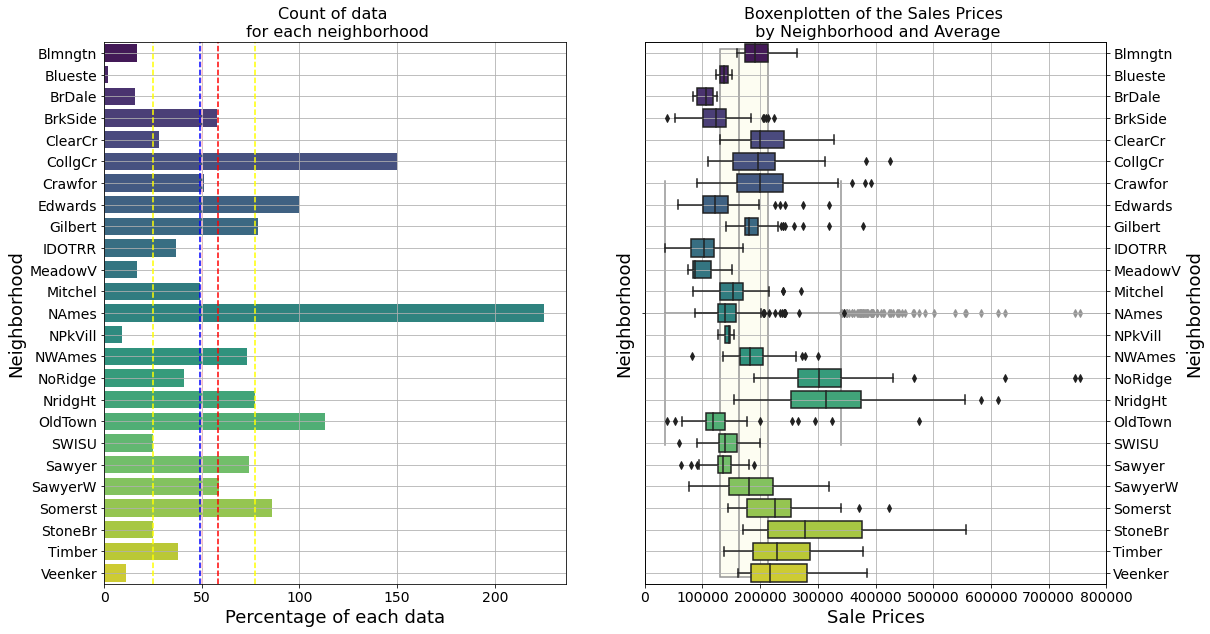

In [249]:
fig, axs = plt.subplots(1, 2, figsize=(18,10))

bp = sns.barplot(data = df_proportion_neigh, x= "DataCount", y= "Neighborhood", palette = "viridis", ax = axs[0])
bp.grid()
bp.set_ylabel("Neighborhood", size=18)
bp.set_xlabel("Percentage of each data", size=18)
bp.tick_params(axis='both', which='major', labelsize=14)
bp.set_title("Count of data \n for each neighborhood", fontsize=16)


bxp = sns.boxplot(data=data[["Neighborhood", "SalePrice"]], x= "SalePrice", y= "Neighborhood", palette = "viridis", ax = axs[1].twinx())
bxp.grid()
bxp.set_ylabel("Neighborhood",size=18)
bxp.set_xlim(0, 800000)
bxp.tick_params(axis='both', which='major', labelsize=14)
bxp.set_title("Boxenplotten of the Sales Prices \n by Neighborhood and Average", fontsize=16)


bxp1 = sns.boxplot(data=data[["Neighborhood", "SalePrice"]], x= "SalePrice", y=None, ax = axs[1], color= "ivory",)
bxp1.grid()
bxp1.set_ylim(0.41,-0.41)
bxp1.set_xlim(0, 800000)
bxp1.tick_params(axis='both', which='major', labelsize=14)
bxp1.set_xlabel("Sale Prices", size=18)


# create a dictionnary with the statistics and the colors for the lines. Then, unpack the dictionnary.
dict_stats = {"mean": "red", "50%":"blue", "std":"pink", "75%": "yellow", "25%":"yellow"}
for stat, color in dict_stats.items():
  bp.axvline(df_proportion_neigh["DataCount"].describe()[stat], color = color).set_linestyle("--")


fig.tight_layout(pad=5)
#plt.savefig('Count of data and Neighborhood vs SalePrice.jpg',  dpi=100)

📕 The dataset is unbalanced considering the Neighborhoods. Some are more represented than other. For example, NAmes has 15.4% of the data while Blueste 0.14%. Might need to collect more data in these neighborhood before drawing conclusions from them

# Segmentation of the neighborhood based on their prices

### Transformation of categorical data

As the data are categorical, we have to transform them to numerical values. I decided to use OneHotEncoder from the sciklearn library.

In [250]:
df = data[["Neighborhood", "SalePrice"]].copy()

In [251]:
ohe = OneHotEncoder(sparse=False)
neighborhood_encoded = ohe.fit_transform(df[["Neighborhood"]])


📕 Visualise the neighborhood used by the OneHotEncoder

In [252]:
ohe.categories_[0]

array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object)

📕 Reintroduce the encoded values to the data frame and drop the column neighborhood to a reduced dataframe.

In [253]:
df[ohe.categories_[0]] = neighborhood_encoded
df_red = df.drop(columns=["Neighborhood"])
df_red.head()

,SalePrice,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
852,215000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,178740,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,160200,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1020,213490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
640,264561,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hierarchical clustering using a dendrogram

📕We want to allocate our data to clusters using hierarchical clustering and a dendrogram

In [254]:
hierclust = linkage(df_red, method = "ward")

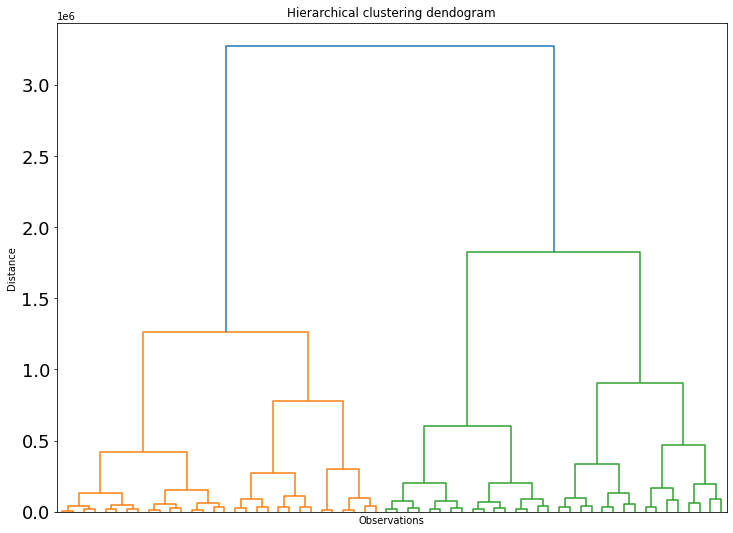

In [338]:
plt.figure(figsize=(12,9))
plt.title("Hierarchical clustering dendogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hierclust, 
           truncate_mode="level", p= 5,
           show_leaf_counts=False, 
           no_labels=True,)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('Dendrogram.jpg')

📕 With this approach, the data are segmented in two clusters.

## KMean Clustering: Determine the number of cluster 

📕 Determine the number of clusters by the elbow method.

In [256]:
wcss = []
for i in range(1,11):
  km = KMeans(n_clusters=i, init= "k-means++", random_state=42)
  km.fit(df_red)
  wcss.append(km.inertia_)

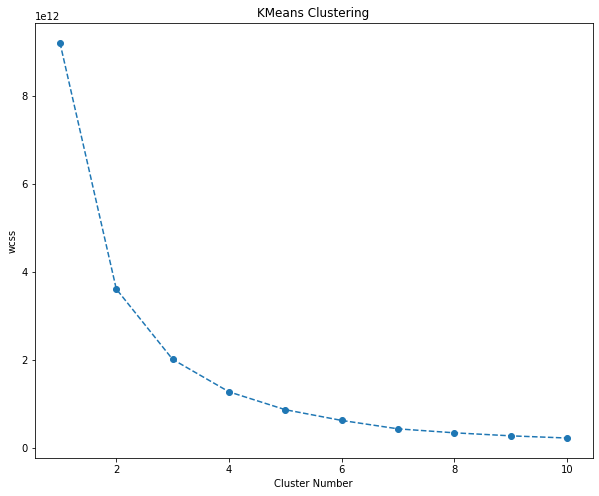

In [257]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker = "o", linestyle= "--")
plt.xlabel("Cluster Number")
plt.ylabel("wcss")
plt.title("KMeans Clustering")
plt.plot();
plt.savefig('KMean_Clusters_Graph.jpg')

As it is unclear between 2 and 3, we use [kneed](https://github.com/arvkevi/kneed) algorithm which detects the elbow

In [258]:
kl = KneeLocator(range(1,11), wcss, curve="convex", direction="decreasing")
kl.elbow

3

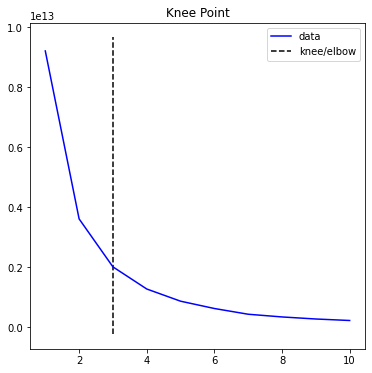

In [259]:
kl.plot_knee()

We thus choose 3 clusters.

In [260]:
km = KMeans(n_clusters=3, init= "k-means++", random_state=42)
km.fit(df_red)

KMeans(n_clusters=3, random_state=42)

We can see that the clusters are imbalanced

In [261]:
Counter(km.labels_)

Counter({2: 539, 0: 801, 1: 120})

In [263]:
df["Segment KMean"] = km.labels_
df_red["Segment KMean"] = km.labels_

In [264]:
df_segment_analysis = df_red.groupby(["Segment KMean"]).mean()

📕 We can attribute the clusters to different sale prices.

In [265]:
df_segment_analysis

,SalePrice,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Segment KMean,,,,,,,,,,,,,,,,,,,,,,,,,,
0,129105.011236,0.003745,0.002497,0.019975,0.063670,0.006242,0.054931,0.021223,0.109863,0.017478,0.046192,0.021223,0.049938,0.243446,0.011236,0.027466,0.000000,0.002497,0.132335,0.024969,0.086142,0.028714,0.017478,0.001248,0.004994,0.002497
1,372625.941667,0.000000,0.000000,0.000000,0.000000,0.016667,0.050000,0.050000,0.008333,0.016667,0.000000,0.000000,0.000000,0.008333,0.000000,0.008333,0.175000,0.350000,0.025000,0.000000,0.000000,0.025000,0.083333,0.091667,0.066667,0.025000
2,215244.376623,0.025974,0.000000,0.000000,0.012987,0.038961,0.185529,0.051948,0.020408,0.116883,0.000000,0.000000,0.016698,0.053803,0.000000,0.092764,0.037106,0.061224,0.007421,0.009276,0.009276,0.061224,0.115028,0.024119,0.048237,0.011132


📕3 clusters based on the price. Low, Middle, High. 


In [267]:
df["Labels"] = df["Segment KMean"].map({0: "Low Prices", 1: "High Prices", 2: "Medium Prices"})
df.head()

# Analysis of the results

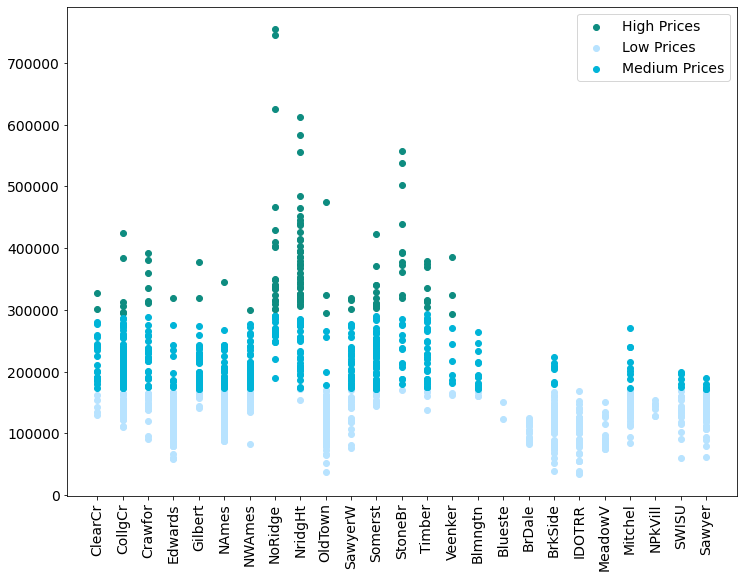

In [269]:
list_colors = ["#0e8c80", "#b8e3ff","#00b4d8"]
plt.figure(figsize=(12,9))
for i, color in zip([1,0,2], list_colors):
  plt.scatter(data=df[df["Segment KMean"]==i], x= "Neighborhood", y="SalePrice", c=color)
  plt.xticks(rotation=90, fontsize=9)
plt.legend(labels=["High Prices", "Low Prices", "Medium Prices"], prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("Neighborhood vs Price with Segmentation.jpg")

📕 Proportions of each segment.

In [270]:
segm_prop = (df[["SalePrice", "Segment KMean"]].groupby(["Segment KMean"]).count())/df.shape[0]
segm_prop = segm_prop.rename(columns= {"SalePrice": "Segment Proportions"})
segm_prop = segm_prop.rename(index= {0: "Medium Prices", 1: "High Prices", 2: "Low Prices"})
segm_prop.head()

,Segment Proportions
Segment KMean,
Medium Prices,0.548630
High Prices,0.082192
Low Prices,0.369178


📕 Now we can plot the proportions of the different segments for each neighborhood

In [273]:
list_col = ["NoRidge", "NridgHt", "StoneBr", "Veenker", "Timber", 
            "Somerst", "Crawfor", "Blmngtn", "CollgCr", "NWAmes",  
             "Gilbert", "ClearCr",  "SawyerW", "NAmes", "Edwards", 
            "OldTown", "SWISU", "Mitchel", "BrkSide", "Sawyer",
            "IDOTRR", "MeadowV", "NPkVill", "BrDale", "Blueste"]

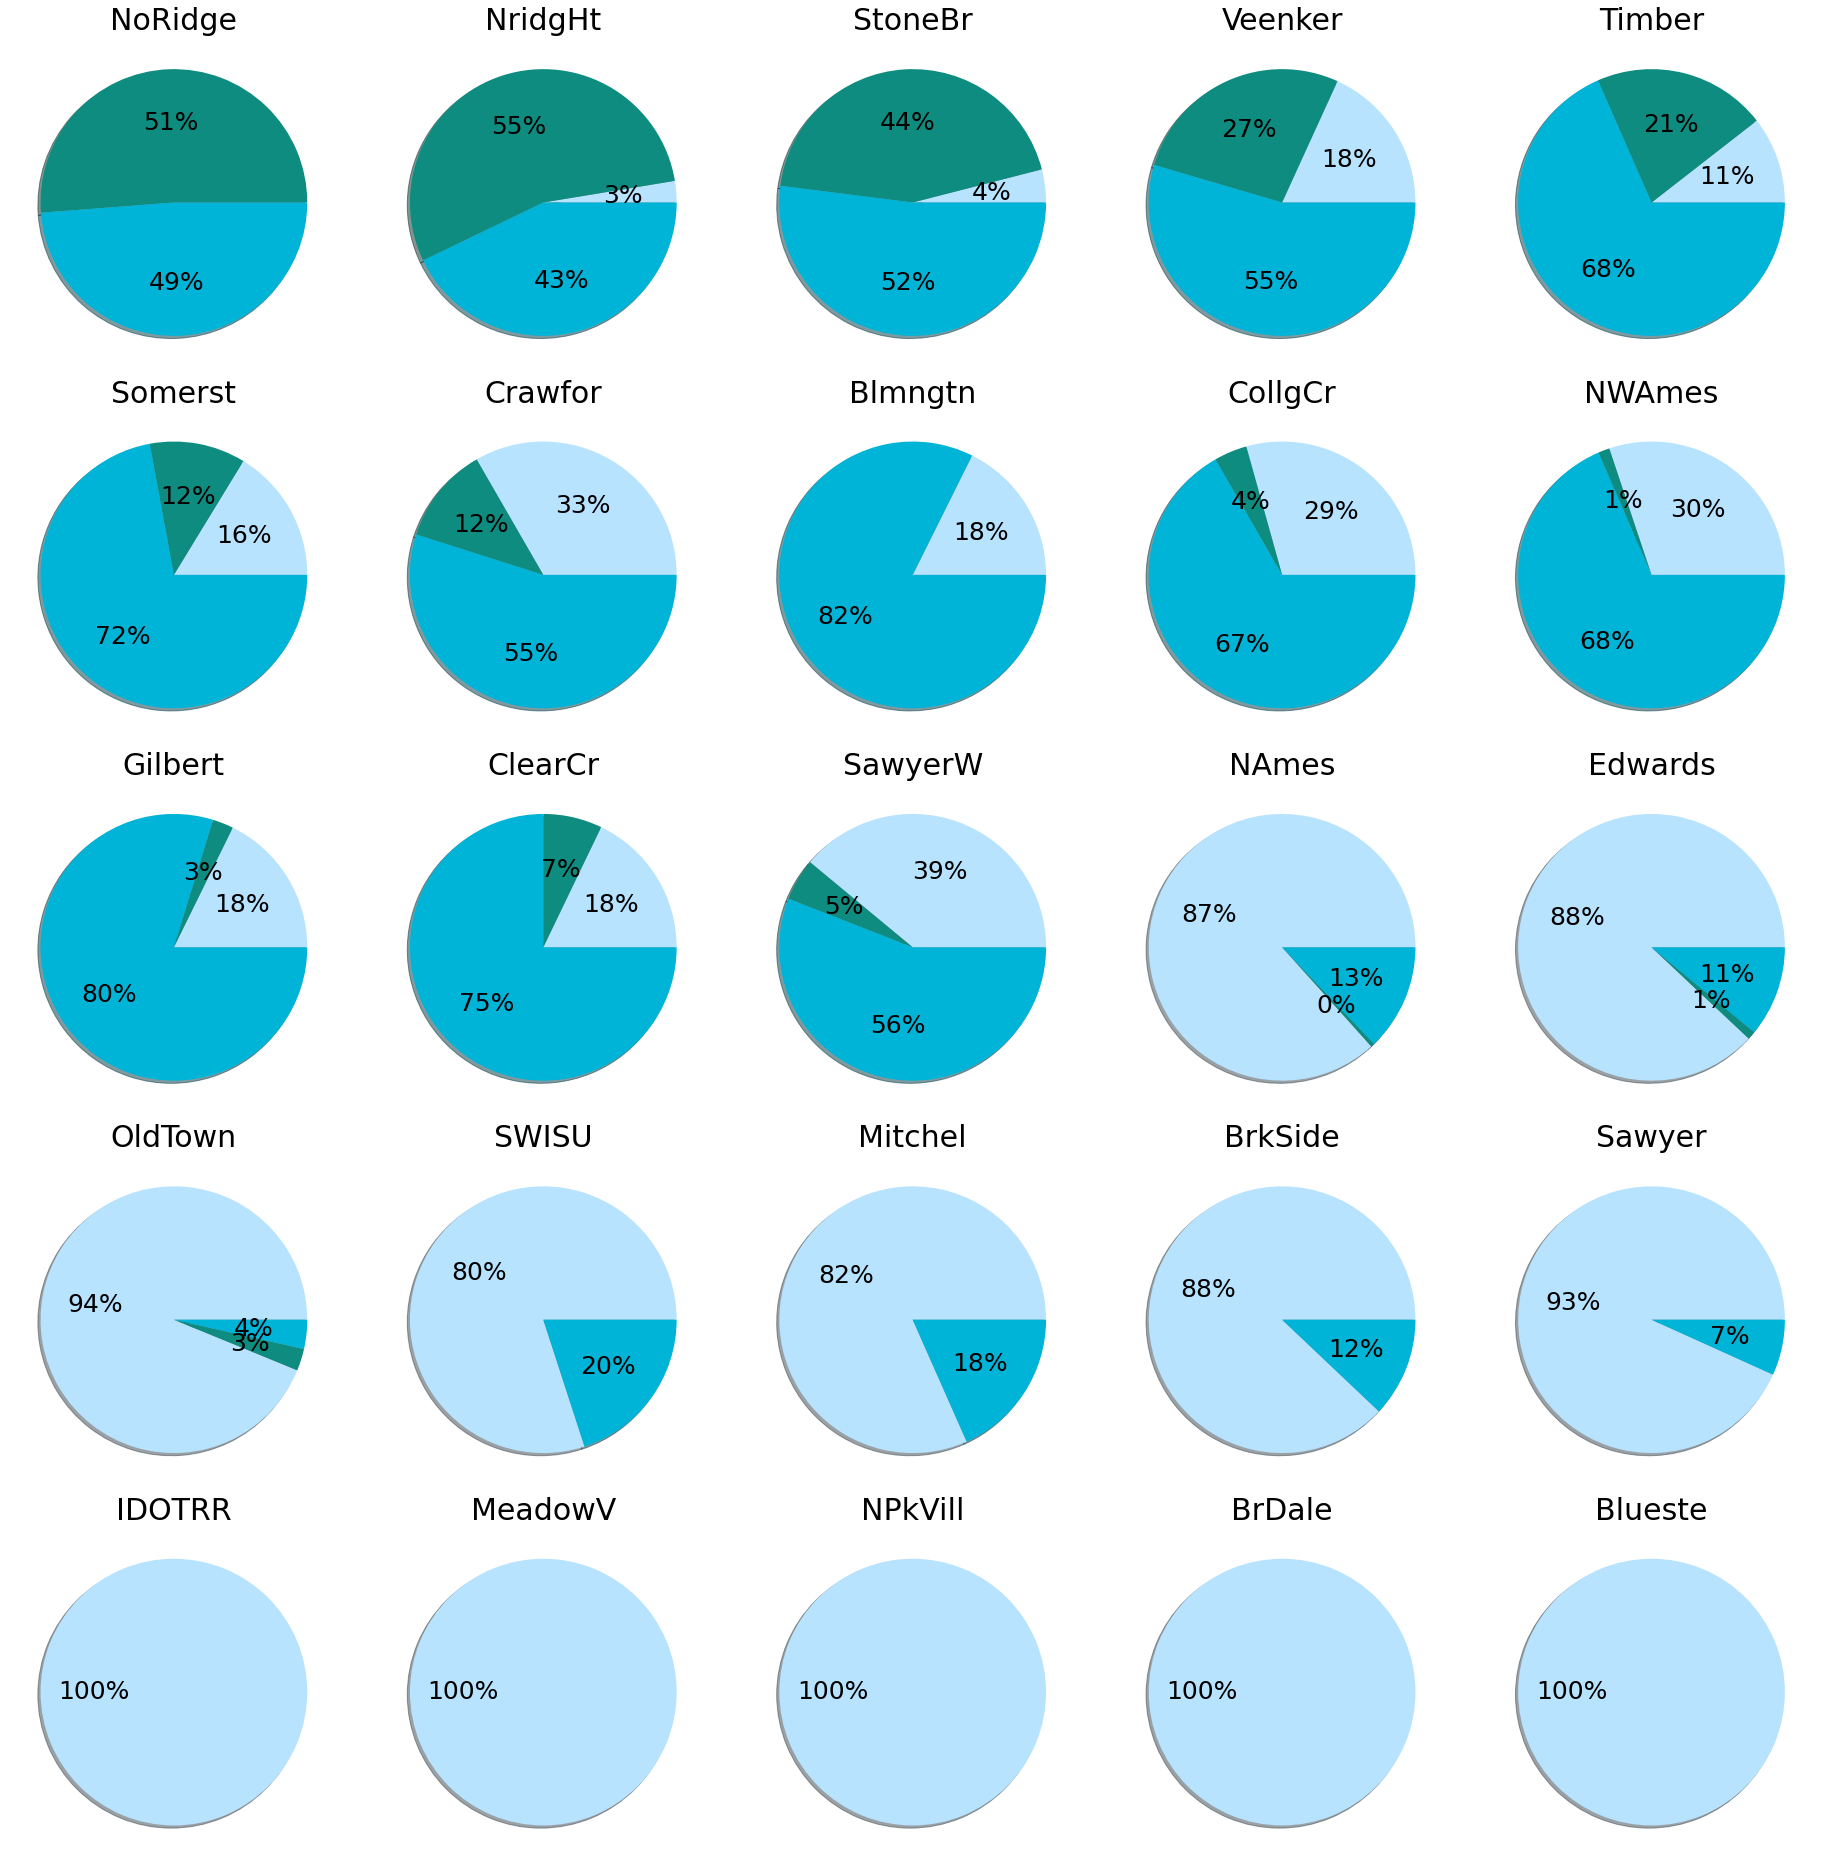

In [274]:
label_holder = {}
fig, axs = plt.subplots(5,5,figsize=(30,10))

for ax, name in zip(axs.ravel(), list_col):
  label_holder["segm_prop_" + str(name)] = df[df["Neighborhood"] == name]
  label_holder["segm_prop_" + str(name)] = label_holder["segm_prop_" + str(name)][["SalePrice", "Segment KMean"]].groupby(["Segment KMean"]).count()/(label_holder["segm_prop_" + str(name)].shape[0])
  label_holder["segm_prop_" + str(name)] = label_holder["segm_prop_" + str(name)].rename(columns= {"SalePrice": "Segment Proportions"})
  label_holder["segm_prop_" + str(name)] = label_holder["segm_prop_" + str(name)].rename(index={0: "Low Prices", 1: "High Prices", 2: "Medium Prices"})
  ax.pie(label_holder["segm_prop_" + str(name)]["Segment Proportions"],
        autopct = "%1.0f%%", colors = ["#00b4d8" if l == "Medium Prices" else "#0e8c80" if l == "High Prices" else "#b8e3ff" for l in label_holder["segm_prop_" + str(name)].index],
         shadow=True, textprops={'size': 25})
  fig.set_figwidth(26)
  fig.set_figheight(26)
  fig.tight_layout(pad=1)
  ax.set_title(f"{name}", size=30)
plt.savefig('All Neighborhood divided by segments pie chart.jpg')

**Conclusion: By analysing the data statistically and using KMean clustering, we now have a deeper understanding of the Neighborhood and Sale Price in the Ames dataset. As the dataset has 80 columns, we could go further in the analysis and maybe determine what can influence the sale price.**

# Supplement: Standard scaler on price

This is an additional step. Note that for my analysis, I did not scaled the SalePrice, so I wanted to very if this will have any influence. The answer is that we still have 3 segments, but some few data do not belong to the same segments. Therefore, for this study, scaling didn't influenced the output.

In [312]:
df_red_ss = data[["SalePrice", "Neighborhood"]].copy()

In [313]:
df_red_ss = df_red_ss.sort_values("Neighborhood")

In [314]:
ohe = OneHotEncoder(sparse=False)
neighborhood_encoded = ohe.fit_transform(df[["Neighborhood"]])
df_red_ss[ohe.categories_[0]] = neighborhood_encoded
df_red_ss

,SalePrice,Neighborhood,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
852,215000,Blmngtn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,175900,Blmngtn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444,172500,Blmngtn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,191000,Blmngtn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560,234000,Blmngtn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,245500,Veenker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,181500,Veenker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
765,270000,Veenker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [315]:
se = StandardScaler()
df_red_ss["Scaled Price"] = se.fit_transform(df_red_ss[["SalePrice"]])
#df_red_ss

In [317]:
df_ss_ohe = df_red_ss.drop(columns= ["SalePrice", "Neighborhood"])
#df_ss_ohe

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Scaled Price
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.429121
1416,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.063227
444,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.106040
1024,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126913
560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.668370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.813178
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.007288
765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.121683


In [319]:
wcss_ss = []
for i in range(1,11):
  km = KMeans(n_clusters=i, init= "k-means++", random_state=42)
  km.fit(df_ss_ohe)
  wcss_ss.append(km.inertia_)

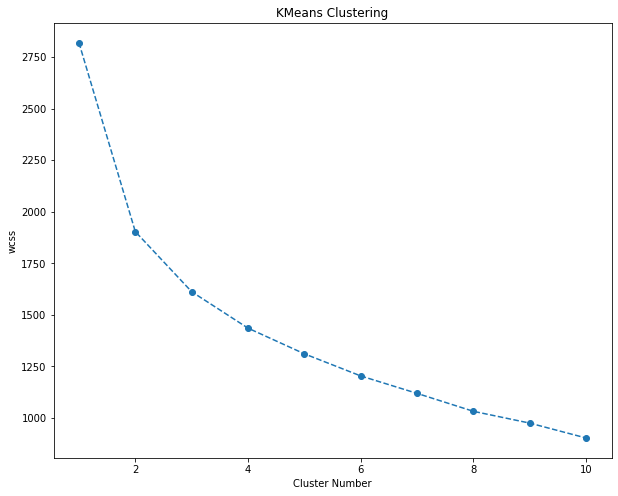

In [320]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss_ss, marker = "o", linestyle= "--")
plt.xlabel("Cluster Number")
plt.ylabel("wcss")
plt.title("KMeans Clustering")
plt.plot();

In [321]:
kl_ss = KneeLocator(range(1,11), wcss_ss, curve="convex", direction="decreasing")
kl_ss.elbow

3

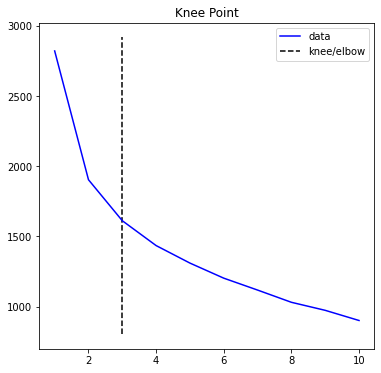

In [322]:
kl_ss.plot_knee()

In [323]:
km = KMeans(n_clusters=3, init= "k-means++", random_state=42)
km.fit(df_ss_ohe)

KMeans(n_clusters=3, random_state=42)

In [324]:
df_ss_ohe["Segment KMean"] = km.labels_

In [325]:
df_red_ss["Segment"] = km.labels_

The clustering is relatively similar

Text(0.5, 1.0, 'Non Scaled Prices')

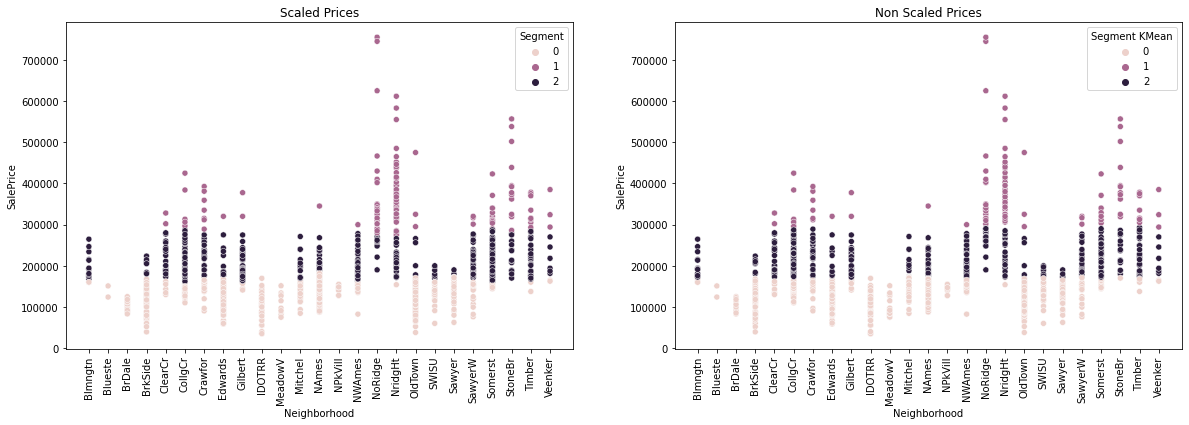

In [336]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
a = sns.scatterplot(ax=axes[0], x= df_red_ss["Neighborhood"], y=df_red_ss["SalePrice"], hue= df_red_ss["Segment"])
b = sns.scatterplot(ax=axes[1], x= df["Neighborhood"], y=df["SalePrice"], hue= df["Segment KMean"])
a.tick_params(axis='x', rotation=90)
b.tick_params(axis='x', rotation=90)
a.set_title("Scaled Prices")
b.set_title("Non Scaled Prices")